In [8]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import random

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
import json

In [ ]:
with open("data/product.json","r") as f:
    product_datas = json.load(f)
product_datas

[{'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy'],
  'tech1': '',
  'description': [],
  'fit': '',
  'title': '',
  'tech2': '',
  'brand': "Visit Amazon's Elizabeth Moon Page",
  'feature': [],
  'rank': '88,963 Paid in Kindle Store (',
  'details': {'File Size:': '2199 KB',
   'Print Length:': '314 pages',
   'Publisher:': 'Del Rey (September 30, 2003)',
   'Publication Date:': 'September 30, 2003',
   'Language:': 'English',
   'ASIN:': 'B000FBJBA4',
   'Word Wise:': 'Enabled',
   'Lending:': 'Not Enabled'},
  'main_cat': 'Buy a Kindle',
  'similar_item': '',
  'date': '',
  'price': '',
  'imageURL': [],
  'imageURLHighRes': [],
  'ProductID': 'B000FBJBA4'},
 {'category': ['Kindle Store',
   'Kindle eBooks',
   'Politics & Social Sciences',
   '</span>'],
  'tech1': '',
  'description': [],
  'fit': '',
  'title': '',
  'tech2': '',
  'brand': "Visit Amazon's Karl Marx Page",
  'feature': [],
  'rank': '1,358,073 Paid in Kindle Store (',
  'details': {'F

# Collaborative Filtering

In [2]:
def build_ncf_model(n_users, n_items, embed_size, output_layer='dot'):
    '''
    params:
        n_users <int>: The number of user embedding vectors
        n_items <int>: The number of item embedding vectors
        embed_size <int>: The dimension of each embedding vector
        output_layer <str>: Indicates the instantiation of NCF to use, available options are either 'dot' or 'mlp'

    return:
        a keras Model object for the constructed ncf model 
    '''
    # Get the users and items input
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')


    # Get the embeddings of users and items
    user_emb = Embedding(output_dim=embed_size, input_dim=n_users, input_length=1)(user_input)
    user_emb = Reshape((embed_size,))(user_emb)
    item_emb = Embedding(output_dim=embed_size, input_dim=n_items, input_length=1)(item_input)
    item_emb = Reshape((embed_size,))(item_emb)


    if output_layer == 'dot':
        # Compute the dot product of users' and items' embeddings as the model output
        model_output = Dot(axes=1)([user_emb, item_emb])

    elif output_layer == 'mlp':
        # Concatenate the users' and items' embeddings as the input of MLP
        mlp_input = Concatenate()([user_emb, item_emb])
        
        # Perform higher-level feature extraction with 128 units
        mlp_layer_1 = Dense(units=128, activation='relu')(mlp_input)
        
        # The layer with 128 units learns more abstract representations
        # by capturing complex patterns and interactions in the data
        
        # Perform feature transformation with 64 units
        mlp_layer_2 = Dense(units=64, activation='relu')(mlp_layer_1)
        
        # The layer with 64 units further refines the learned representations
        # and captures more intricate patterns in the data
        
        # Perform feature transformation with 32 units
        mlp_layer_3 = Dense(units=32, activation='relu')(mlp_layer_2)
        
        # The layer with 32 units continues to extract higher-level features
        # and captures more fine-grained patterns in the data
        
        # Generate the final prediction with 1 unit
        model_output = Dense(units=1)(mlp_layer_3)
        
    else:
        raise NotImplementedError

    model = Model(inputs=[user_input, item_input], outputs=model_output)
    return model

In [3]:
re_df = pd.read_csv("data/review.csv")
val_df = pd.read_csv("data/validation.csv")

In [4]:
reviewer_set = set(re_df.ReviewerID.unique())
product_set = set(re_df.ProductID.unique())

reviewer_vocab = dict(zip(reviewer_set, range(1, len(reviewer_set) + 1)))
reviewer_vocab['unk'] = 0 
n_users = len(reviewer_vocab)

product_vocab = dict(zip(product_set, range(1, len(product_set) + 1)))
product_vocab['unk'] = 0
n_items = len(product_vocab)

In [5]:
re_reviewer = re_df.ReviewerID.apply(lambda x: reviewer_vocab[x]).values
re_product = re_df.ProductID.apply(lambda x: product_vocab[x]).values
val_reviewer = val_df.ReviewerID.apply(lambda x: reviewer_vocab[x] if x in reviewer_vocab else 0).values
val_product = val_df.ProductID.apply(lambda x: product_vocab[x] if x in product_vocab else 0).values

In [6]:
val_reviewer

array([2495,  221, 2229, ...,   71,    0,    0], dtype=int64)

In [6]:
re_ratings = re_df.Star.values
val_ratings = val_df.Star.values

In [7]:
from math import sqrt

import pandas as pd
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             precision_recall_fscore_support)


# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [24]:
model = build_ncf_model(n_users, n_items, embed_size=100, output_layer='mlp') #SGD
model.compile(optimizer='SGD', loss='mse') #SGD: 1. SGD has been observed to converge to sharp minima more effectively than Adam 2. SGD can be more robust to noisy gradients compared to Adam. In some cases, Adam's adaptive learning rate and momentum can overly amplify the effect of noisy gradients, leading to erratic updates.

history = model.fit(
        [re_reviewer, re_product], 
        re_ratings, 
        epochs=5, 
        verbose=1,
        callbacks=[ModelCheckpoint('models/model.keras')])

Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3279
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7199
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5641
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5228
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4968


# For testing how the number of epochs and embedding affect the performance

Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3082
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6894
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5557
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5180
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4931
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2824
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6967
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5572
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5190
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4944
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3430
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6772
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5499
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5122
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4880
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2665
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6564
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5447
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5095
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4863
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4900
Epoch 2/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7133
Epoch 3/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5545
Epoch 4/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5114
Epoch 5/5
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4848
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3514
Epoch 2/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7317
Epoch 3/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5650
Epoch 4/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5223
Epoch 5/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4962
Epoch 6/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4760
Epoch 7/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4599
Epoch 8/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4468
Epoch 9/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4357
Epoch 10/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4263
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4086
Epoch 2/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7479
Epoch 3/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5695
Epoch 4/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5233
Epoch 5/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4964
Epoch 6/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4758
Epoch 7/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4595
Epoch 8/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4459
Epoch 9/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4342
Epoch 10/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4236
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4833
Epoch 2/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7177
Epoch 3/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5573
Epoch 4/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5136
Epoch 5/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4876
Epoch 6/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4684
Epoch 7/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4530
Epoch 8/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4399
Epoch 9/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4283
Epoch 10/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4177
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3242
Epoch 2/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6727
Epoch 3/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5487
Epoch 4/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5110
Epoch 5/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4868
Epoch 6/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4685
Epoch 7/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4539
Epoch 8/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4414
Epoch 9/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4301
Epoch 10/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4194
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3092
Epoch 2/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6726
Epoch 3/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5422
Epoch 4/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5038
Epoch 5/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4795
Epoch 6/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4614
Epoch 7/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4465
Epoch 8/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4335
Epoch 9/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4215
Epoch 10/10
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/15


c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4582
Epoch 2/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7696
Epoch 3/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5785
Epoch 4/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5312
Epoch 5/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5038
Epoch 6/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4818
Epoch 7/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4640
Epoch 8/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4497
Epoch 9/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4376
Epoch 10/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4274
Epoch 11/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4182
Epoch 12/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4097
Epoch 13/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4018
Epoch 14/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3939
Epoch 15/15
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.4899
Epoch 2/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7325
Epoch 3/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5597
Epoch 4/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5155
Epoch 5/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4881
Epoch 6/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4676
Epoch 7/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4516
Epoch 8/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4386
Epoch 9/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4271
Epoch 10/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4167
Epoch 11/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4068
Epoch 12/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3971
Epoch 13/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3869
Epoch 14/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3757
Epoch 15/15
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3153
Epoch 2/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6698
Epoch 3/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5478
Epoch 4/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5113
Epoch 5/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4867
Epoch 6/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4673
Epoch 7/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4515
Epoch 8/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4382
Epoch 9/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4260
Epoch 10/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4147
Epoch 11/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4040
Epoch 12/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3931
Epoch 13/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3813
Epoch 14/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3684
Epoch 15/15
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3228
Epoch 2/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7192
Epoch 3/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5583
Epoch 4/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5148
Epoch 5/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4888
Epoch 6/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4693
Epoch 7/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4537
Epoch 8/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4404
Epoch 9/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4282
Epoch 10/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4165
Epoch 11/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4049
Epoch 12/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3928
Epoch 13/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3797
Epoch 14/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3650
Epoch 15/15
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3658
Epoch 2/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6847
Epoch 3/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5522
Epoch 4/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5143
Epoch 5/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4896
Epoch 6/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4703
Epoch 7/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4545
Epoch 8/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4407
Epoch 9/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4278
Epoch 10/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4153
Epoch 11/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4025
Epoch 12/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3890
Epoch 13/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3737
Epoch 14/15
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3563
Epoch 15/15
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3215
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7007
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5560
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5192
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4947
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4753
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4598
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4469
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4359
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4261
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4171
Epoch 12/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4086
Epoch 13/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4003
Epoch 14/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3918
Epoch 15/20
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.3033
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6924
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5579
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5200
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4950
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4754
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4597
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4469
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4358
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4259
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4167
Epoch 12/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4077
Epoch 13/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3990
Epoch 14/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3900
Epoch 15/20
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3047
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6889
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5500
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5101
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4845
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4650
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4493
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4360
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4239
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4124
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4010
Epoch 12/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3894
Epoch 13/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3766
Epoch 14/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3623
Epoch 15/20
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2764
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6894
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5522
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5148
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4905
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4716
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4563
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4430
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4312
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4202
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4096
Epoch 12/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3990
Epoch 13/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3876
Epoch 14/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3753
Epoch 15/20
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2380
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6442
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5395
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5046
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4816
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4643
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4501
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4378
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4265
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4153
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4040
Epoch 12/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3919
Epoch 13/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3784
Epoch 14/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3634
Epoch 15/20
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3661
Epoch 2/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7296
Epoch 3/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5644
Epoch 4/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5204
Epoch 5/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4932
Epoch 6/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4721
Epoch 7/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4557
Epoch 8/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4423
Epoch 9/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4309
Epoch 10/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4208
Epoch 11/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4117
Epoch 12/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4030
Epoch 13/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3940
Epoch 14/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3847
Epoch 15/25
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.4885
Epoch 2/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7617
Epoch 3/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5740
Epoch 4/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5252
Epoch 5/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4960
Epoch 6/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4734
Epoch 7/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4555
Epoch 8/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4407
Epoch 9/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4284
Epoch 10/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4174
Epoch 11/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4071
Epoch 12/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3970
Epoch 13/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3865
Epoch 14/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3752
Epoch 15/25
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3565
Epoch 2/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6829
Epoch 3/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5508
Epoch 4/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5121
Epoch 5/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4864
Epoch 6/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4669
Epoch 7/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4513
Epoch 8/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4383
Epoch 9/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4270
Epoch 10/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4166
Epoch 11/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4067
Epoch 12/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3968
Epoch 13/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3864
Epoch 14/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3747
Epoch 15/25
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4260
Epoch 2/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6918
Epoch 3/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5520
Epoch 4/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5155
Epoch 5/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4912
Epoch 6/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4722
Epoch 7/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4569
Epoch 8/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4439
Epoch 9/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4322
Epoch 10/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4211
Epoch 11/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4102
Epoch 12/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3988
Epoch 13/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3865
Epoch 14/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3730
Epoch 15/25
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2986
Epoch 2/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6865
Epoch 3/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5512
Epoch 4/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5131
Epoch 5/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4886
Epoch 6/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4699
Epoch 7/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4549
Epoch 8/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4421
Epoch 9/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4304
Epoch 10/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4191
Epoch 11/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4078
Epoch 12/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3957
Epoch 13/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3823
Epoch 14/25
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3672
Epoch 15/25
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3772
Epoch 2/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6922
Epoch 3/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5526
Epoch 4/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5146
Epoch 5/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4896
Epoch 6/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4704
Epoch 7/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4549
Epoch 8/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4422
Epoch 9/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4313
Epoch 10/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4216
Epoch 11/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4126
Epoch 12/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4039
Epoch 13/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3955
Epoch 14/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3869
Epoch 15/30
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3603
Epoch 2/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6996
Epoch 3/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5569
Epoch 4/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5182
Epoch 5/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4927
Epoch 6/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4727
Epoch 7/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4566
Epoch 8/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4428
Epoch 9/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4310
Epoch 10/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4202
Epoch 11/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4103
Epoch 12/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4008
Epoch 13/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3912
Epoch 14/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3814
Epoch 15/30
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.5383
Epoch 2/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7397
Epoch 3/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5654
Epoch 4/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5204
Epoch 5/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4943
Epoch 6/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4742
Epoch 7/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4577
Epoch 8/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4436
Epoch 9/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4317
Epoch 10/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4205
Epoch 11/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4101
Epoch 12/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3997
Epoch 13/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3891
Epoch 14/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3777
Epoch 15/30
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.3491
Epoch 2/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6767
Epoch 3/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5499
Epoch 4/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5129
Epoch 5/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4884
Epoch 6/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4694
Epoch 7/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4541
Epoch 8/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4409
Epoch 9/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4292
Epoch 10/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4182
Epoch 11/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4077
Epoch 12/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3971
Epoch 13/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3860
Epoch 14/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3741
Epoch 15/30
1647/1647 ━━━━━━━━━━━━━━━━━━

c:\Users\hill6\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.3714
Epoch 2/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6865
Epoch 3/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5507
Epoch 4/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5105
Epoch 5/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4845
Epoch 6/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4644
Epoch 7/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4482
Epoch 8/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4342
Epoch 9/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4215
Epoch 10/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4096
Epoch 11/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3975
Epoch 12/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3848
Epoch 13/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3708
Epoch 14/30
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3548
Epoch 15/30
1647/1647 ━━━━━━━━━━━━━━━━━━

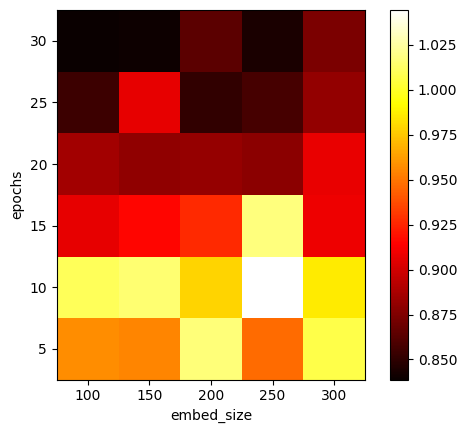

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values for epochs and embed_size
epochs = [5, 10, 15, 20, 25, 30]
embed_size = [100, 150, 200, 250, 300]

# Create an empty array to store the validation RMSE values
result = []

# Loop through the combinations of epochs and embed_size
for num_epochs in epochs:
    row = []
    for size in embed_size:
        # Build and compile the model with the desired parameters
        model = build_ncf_model(n_users, n_items, embed_size=size, output_layer='mlp')
        model.compile(optimizer='SGD', loss='mse')

        # Fit the model on the training data
        history = model.fit(
            [re_reviewer, re_product], 
            re_ratings, 
            epochs=num_epochs, 
            verbose=1,
            callbacks=[ModelCheckpoint('models/model.keras')])

        # Load the model and make predictions on the validation set
        model = tf.keras.models.load_model('models/model.keras')
        val_pred = model.predict([val_reviewer, val_product])

        # Calculate RMSE
        val_rmse = rmse(val_pred, val_ratings)
        print(val_rmse)
        row.append(val_rmse)

    result.append(row)

# Convert the result list to a numpy array and reshape it
result = np.array(result).reshape(len(epochs), len(embed_size))

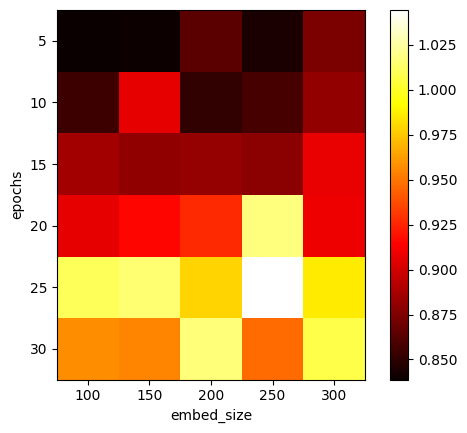

In [23]:
# Plot the heatmap
plt.imshow(result, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=embed_size)
plt.xlabel("embed_size")
plt.yticks(ticks=[0, 1, 2, 3, 4, 5], labels=epochs)
plt.ylabel("epochs")
plt.show()

In [25]:
model = tf.keras.models.load_model('models/model.keras')
val_pred = model.predict([val_reviewer, val_product])
print("Validation set RMSE: ", rmse(val_pred, val_ratings))

df_predictions = pd.DataFrame({
    'ReviewerID': val_df['ReviewerID'],
    'ProductID': val_df['ProductID'],
    'Star': val_pred.flatten()
})
df_predictions.to_csv('validation_prediction.csv', index=False)

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation set RMSE:  0.8392259764601201


In [12]:
test_df = pd.read_csv("data/prediction.csv")

test_reviewer_set = set(test_df.ReviewerID.unique())
test_product_set = set(test_df.ProductID.unique())

test_vocab = dict(zip(test_reviewer_set, range(1, len(test_reviewer_set) + 1)))
test_vocab['unk'] = 0 
test_n_users = len(test_vocab)

test_product_vocab = dict(zip(test_product_set, range(1, len(test_product_set) + 1)))
test_product_vocab['unk'] = 0
test_n_items = len(test_product_vocab)

test_reviewer = test_df.ReviewerID.apply(lambda x: test_vocab[x]).values
test_product = test_df.ProductID.apply(lambda x: test_product_vocab[x]).values

test_pred = model.predict([test_reviewer, test_product])

#### Unkown compare to what ?
df_predictions = pd.DataFrame({
    'ReviewerID': val_df['ReviewerID'],
    'ProductID': val_df['ProductID'],
    'Star': val_pred.flatten()
})
df_predictions.to_csv('data/prediction.csv', index=False)

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
